# Seed classification

### This section describes the dataset, downloads the dataset, extracts images from it, and finally further divides it into training, validation, and testing sets

## Dataset Description

**The dataset contains images of five classes of local rice grains namely :**

- 2022-1  2022-2 2022-3
- 2022-4  2022-5 2022-6
- 2022-7  2022-8 2022-9

**The dataset has 4900 images in total and is split into :**

* Train, validation and test splits
* Train set contains 13383 images
* validation set contains 1674 images
* Test set contains 1674 images

**checking version of torch**

# Importing necessary libraries

In [1]:
import math
import os
import torch
import torch.nn as nn
from SE import SEAttention
import torch.nn.functional as F
from itertools import cycle
import numpy as np
import torchvision.transforms as transforms
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc, \
    average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt


/home/zhangdejia/.conda/envs/torch37/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("PyTorch version:", torch.__version__)

PyTorch version: 1.12.0+cu116


## Split the Dataset into Training and Validation Sets


**The Dataset is split for actual training 、validation and test.**

- The train-validation-test ratio is  80:10:10
- Total Images in Dataset = 13383
- Images used for actual training = 1674 
- Images used for training validation = 1674 

In [3]:
import os
import random
import shutil
# This function splits the image data into train and validation sets
#Data set to be partitioned
dataset_dir='Dataset_2'
#Location of the partitioned dataset
extract_dir = 'Dataset_2'
def train_validation_split(dataset_path, output_path, split_ratio, seed=120):
    """Builds the train and validation image sets for all image categories given a split ratio"""
    img_categories = os.listdir(dataset_path)  # all the image categories
    if os.path.exists(output_path):
        print('Dataset already exists at the given path')
    else:
        os.makedirs(output_path)
        os.mkdir(output_path + '/train')
        os.mkdir(output_path + '/val')
        os.mkdir(output_path + '/test')
        # for every image category in the dataset build train and val folders with images in them a/c to split_ratio
        print('Splitting dataset into train and validation sets: ')
        for img_category in img_categories:
            print('.', end='')
            # list all the images for this category
            imgs = os.listdir(dataset_path + '/' + img_category)
            # sort and shuffle images randomly
            imgs.sort()
            random.seed(seed)
            random.shuffle(imgs)
            # split the imgs into two halves train and test
            train_split = imgs[:int(split_ratio * len(imgs))]
            val_split = imgs[int(split_ratio * len(imgs)):(int(split_ratio * len(imgs))+int((1-split_ratio) * 0.5 * len(imgs)))]
            test_split=imgs[(int(split_ratio * len(imgs))+int((1-split_ratio) * 0.5 * len(imgs))):]

            # built the train set and copy images
            if not os.path.exists(os.path.join(output_path, 'train', img_category)):
                os.mkdir(os.path.join(output_path, 'train', img_category))
            for img in train_split:
                source = os.path.join(dataset_path, img_category, img)
                dest = os.path.join(output_path, 'train', img_category, img)
                shutil.copy(source, dest)

            # built the val set and copy images
            if not os.path.exists(os.path.join(output_path, 'val', img_category)):
                os.mkdir(os.path.join(output_path, 'val', img_category))
            for img in val_split:
                source = os.path.join(dataset_path, img_category, img)
                dest = os.path.join(output_path, 'val', img_category, img)
                shutil.copy(source, dest)

            # built the test set and copy images
            if not os.path.exists(os.path.join(output_path, 'test', img_category)):
                os.mkdir(os.path.join(output_path, 'test', img_category))
            for img in test_split:
                source = os.path.join(dataset_path, img_category, img)
                dest = os.path.join(output_path, 'test', img_category, img)
                shutil.copy(source, dest)

        print('\nSuccess!!')

# Split the training portion into two splits:
 ## 80% for actual training
 ## 10% for validation
 ## 10% for validation
t_dir = os.path.join(dataset_dir)
# output_path = os.path.join(extract_dir, 'items_train_val_set') # post split path
train_validation_split(t_dir, extract_dir , 0.8)
train_dir = os.path.join(extract_dir, 'train')
validation_dir = os.path.join(extract_dir, 'val')
test_dir = os.path.join(extract_dir, 'test')





Dataset already exists at the given path


# Analyze Data Post Split

In [4]:
"""# Analyze Data Post Split

"""
train_img_categories = os.listdir(train_dir)
validation_img_categories = os.listdir(validation_dir)
test_img_categories = os.listdir(test_dir)

no_of_classes = len(train_img_categories)
print('No of categories/classes: %d\n' % no_of_classes)

print('Object categories in the training set: %d' % len(train_img_categories), end=' ')
print(train_img_categories)
# No of images for each category in the training set
total_train_imgs = 0
for img_cat in train_img_categories:
    path = os.path.join(train_dir, img_cat)
    total_train_imgs += len(os.listdir(path))
    print('No of images for %s = %d' % (img_cat, len(os.listdir(path))))
print('Total no of images in training set = %d\n' % total_train_imgs )

print('Object categories in the validation set: %d' % len(validation_img_categories), end=' ')
print(validation_img_categories)
# No of images for each category in the validation set
total_val_imgs = 0
for img_cat in validation_img_categories:
    path = os.path.join(validation_dir, img_cat)
    total_val_imgs += len(os.listdir(path))
    print('No of images for %s = %d' % (img_cat, len(os.listdir(path))))
print('Total no of images in validation set = %d\n' % total_val_imgs )

print('Object categories in the test set: %d' % len(test_img_categories), end=' ')
print(test_img_categories)
# No of images for each category in the test set
total_test_imgs = 0
for img_cat in test_img_categories:
    path = os.path.join(test_dir, img_cat)
    total_test_imgs += len(os.listdir(path))
    print('No of images for %s = %d' % (img_cat, len(os.listdir(path))))
print('Total no of images in test set = %d' % total_test_imgs )



No of categories/classes: 9

Object categories in the training set: 9 ['2022-9-02', '2022-8-02', '2022-5-02', '2022-1-02', '2022-2-02', '2022-4-02', '2022-7-02', '2022-6-02', '2022-3-02']
No of images for 2022-9-02 = 1487
No of images for 2022-8-02 = 1487
No of images for 2022-5-02 = 1487
No of images for 2022-1-02 = 1487
No of images for 2022-2-02 = 1487
No of images for 2022-4-02 = 1487
No of images for 2022-7-02 = 1487
No of images for 2022-6-02 = 1487
No of images for 2022-3-02 = 1487
Total no of images in training set = 13383

Object categories in the validation set: 9 ['2022-9-02', '2022-8-02', '2022-5-02', '2022-1-02', '2022-2-02', '2022-4-02', '2022-7-02', '2022-6-02', '2022-3-02']
No of images for 2022-9-02 = 186
No of images for 2022-8-02 = 186
No of images for 2022-5-02 = 186
No of images for 2022-1-02 = 186
No of images for 2022-2-02 = 186
No of images for 2022-4-02 = 186
No of images for 2022-7-02 = 186
No of images for 2022-6-02 = 186
No of images for 2022-3-02 = 186
Tota

## Visualize Random Images

Some random images are shown from all three sets.

Actual Training, Training Validation and Test set.

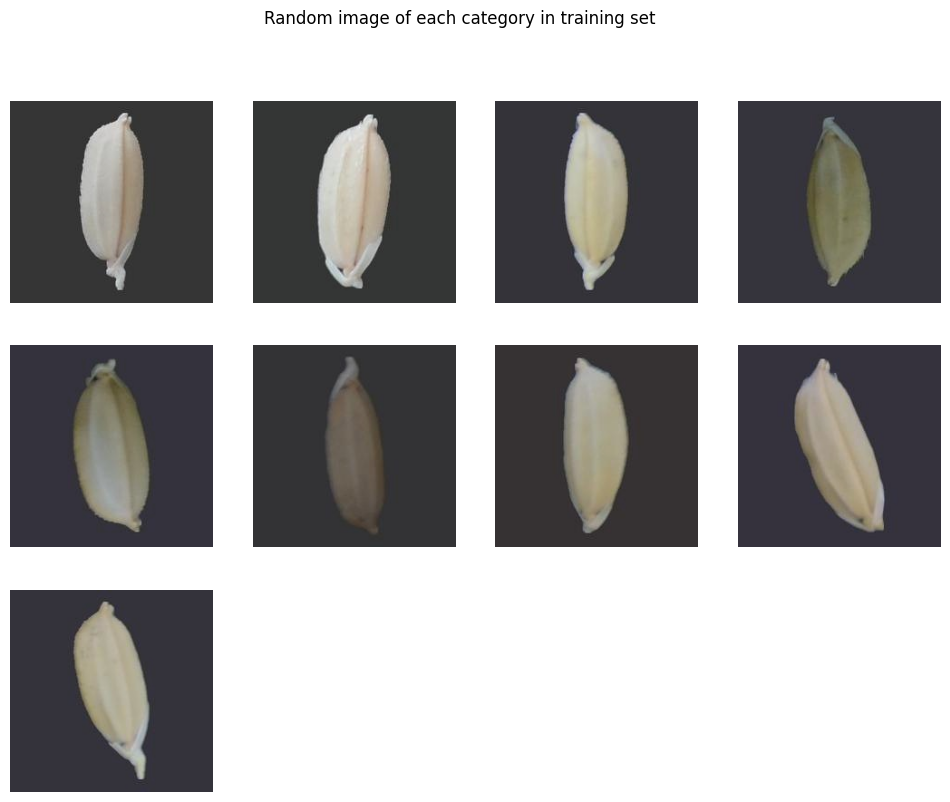

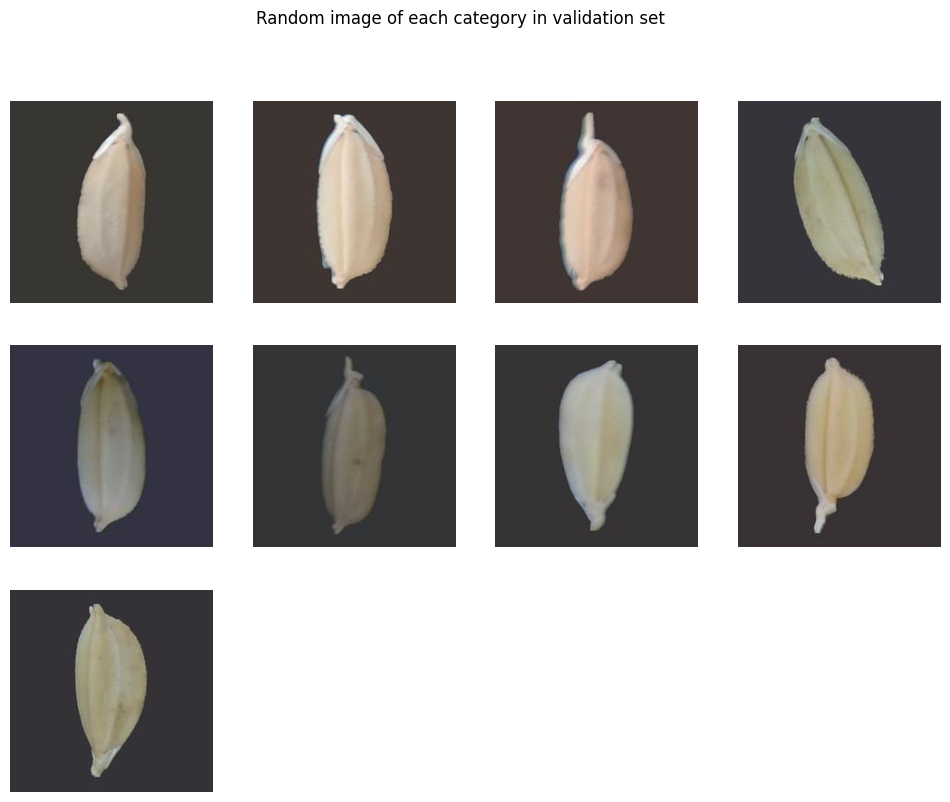

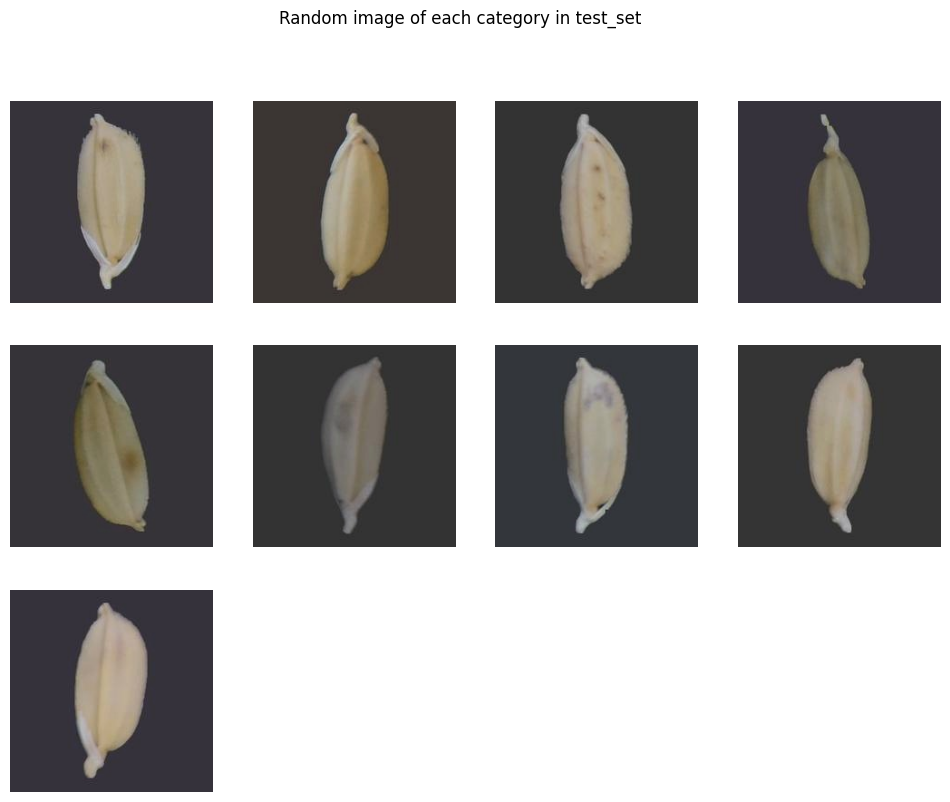

In [5]:
# Show four images of different categories from each of the three sets
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

random_train_imgs_path = [os.path.join(train_dir, cat, random.choice(os.listdir(os.path.join(train_dir, cat)))) for cat in os.listdir(train_dir)]
random_val_imgs_path = [os.path.join(validation_dir, cat, random.choice(os.listdir(os.path.join(validation_dir, cat)))) for cat in os.listdir(validation_dir)]
random_test_imgs_path = [os.path.join(test_dir, cat, random.choice(os.listdir(os.path.join(test_dir, cat)))) for cat in os.listdir(test_dir)]

# Parameters for graph; output images
nrows = 3
ncols = 4

# Set up matplotlib fig
fig = plt.gcf()
fig.set_size_inches(ncols * 3, nrows * 3)
fig.suptitle('Random image of each category in training set')
for i, img_path in enumerate(random_train_imgs_path):
  # Set up subplot; subplot indices start at 1          
  ax = plt.subplot(nrows, ncols, i + 1)
  ax.axis('off')
  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

# Set up matplotlib fig
fig = plt.gcf()
fig.set_size_inches(ncols * 3, nrows * 3)
fig.suptitle('Random image of each category in validation set')
for i, img_path in enumerate(random_val_imgs_path):
  # Set up subplot; subplot indices start at 1          
  ax = plt.subplot(nrows, ncols, i + 1)
  ax.axis('off')
  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

# Set up matplotlib fig
fig = plt.gcf()
fig.set_size_inches(ncols * 3, nrows * 3)
fig.suptitle('Random image of each category in test_set')
for i, img_path in enumerate(random_test_imgs_path):
  # Set up subplot; subplot indices start at 1          
  ax = plt.subplot(nrows, ncols, i + 1)
  ax.axis('off')
  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

## Build Image Classifier

The model is built using the following layers:
* Conv2D - 2D Convolutional Network
* Activation - LeakyReLU
* Batch Normalization
* Max pooling
* Dense - Fully Connected Neural Network
* SEAttention

In [6]:
class RiceLCNN(nn.Module):
    def __init__(self, num_classes):
        super(RiceLCNN, self).__init__()

        self.conv11 = nn.Conv2d(3, 16, kernel_size=1, padding=1)
        # self.bn1 = nn.BatchNorm2d(16)
        self.conv13 = nn.Conv2d(16, 16, kernel_size=3, padding=2)
        # self.bn1 = nn.BatchNorm2d(16)
        self.conv1 = nn.Conv2d(16, 16, kernel_size=1, padding=2)
        # self.ECA = ECAlayer(16)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool2d(4)



        self.conv31 = nn.Conv2d(16, 32, kernel_size=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv33 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.relu3 = nn.LeakyReLU()
        self.pool3 = nn.MaxPool2d(4)




        # self.conv5 = SplitAttentionConv2d(32, 64, 3, 1, padding=1, groups=1, radix=2)
        self.conv51 = nn.Conv2d(32, 64, kernel_size=1, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv53 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=1, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        self.relu5 = nn.LeakyReLU()
        self.pool5 = nn.MaxPool2d(4)

        #se Attention mechanism
        self.se = SEAttention(64)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(64)
        self.relu6 = nn.LeakyReLU()
        self.pool6 = nn.MaxPool2d(2)

        self.conv71 = nn.Conv2d(64, 128, kernel_size=1, padding=1)
        self.bn7 = nn.BatchNorm2d(128)
        self.conv73 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(128)
        self.conv7 = nn.Conv2d(128, 128, kernel_size=1, padding=1)
        self.bn7 = nn.BatchNorm2d(128)
        self.relu7 = nn.LeakyReLU()
        self.pool7 = nn.MaxPool2d(2)

        # self.conv8 = SplitAttentionConv2d(128, 128, 3, 1, padding=1, groups=1, radix=2)
        self.conv8 = nn.Conv2d(128, 224, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(224)
        self.relu8 = nn.LeakyReLU()
        self.pool8 = nn.MaxPool2d(2)



        self.flatten = nn.Flatten()
        self.fc = nn.Linear(224, num_classes)

    def forward(self, x):

        x = self.conv11(x)
        x = self.conv13(x)
        x = self.conv1(x)
        # x = self.ECA(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv31(x)
        # x = self.bn3(x)
        x = self.conv33(x)
        # x = self.bn3(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)


        x = self.conv51(x)
        # x = self.bn5(x)
        x = self.conv53(x)
        # x = self.bn5(x)
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.pool5(x)

        x = self.se(x)
        x = self.conv6(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.pool6(x)

        x = self.conv71(x)
        # x = self.bn7(x)
        x = self.conv73(x)
        # x = self.bn7(x)
        x = self.conv7(x)
        x = self.bn7(x)
        x = self.relu7(x)
        x = self.pool7(x)

        x = self.conv8(x)
        x = self.bn8(x)
        x = self.relu8(x)
        x = self.pool8(x)



        x = self.flatten(x)
        x = self.fc(x)
        return x


# Create the model
model = RiceLCNN(num_classes=9)
# Print the model summary
print(model)
# Calculate parameter quantity
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: ", total_params)

RiceLCNN(
  (conv11): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (conv13): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv31): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv33): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (relu3): LeakyReLU(negative_slope=0.01)
  (pool3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv51): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (bn5): Batc

## Automatic feature extraction

In [7]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize
    transforms.ToTensor(),  # Convert the image into a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Output after conv11:


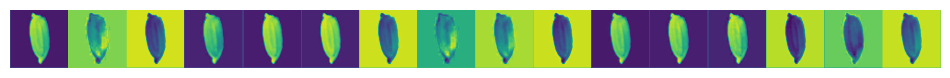

Output after conv31:


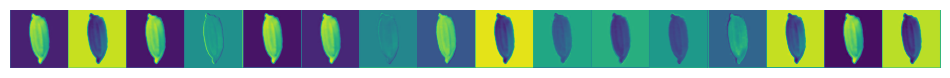

Output after conv31:


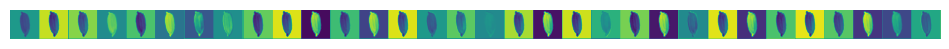

In [8]:
dataset = datasets.ImageFolder(root="Dataset_2/train", transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

# Randomly select an image
dataiter = iter(dataloader)
images, _ = next(dataiter)

# initial model
model = RiceLCNN(num_classes=9)

# Print the output image after each convolutional layer
with torch.no_grad():
    # print("Original Image:")
    # plt.imshow(images.squeeze().permute(1, 2, 0))
    # plt.show()

    out = model.conv11(images)
    print("Output after conv11:")
    fig, axes = plt.subplots(1, out.shape[1], figsize=(12, 3))
    for i in range(out.shape[1]):
        axes[i].imshow(out[0, i].detach().numpy())
        axes[i].axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    # plt.title('conv11')
    plt.show()

    out = model.conv13(out)
    print("Output after conv31:")
    fig, axes = plt.subplots(1, out.shape[1], figsize=(12, 3))
    for i in range(out.shape[1]):
        axes[i].imshow(out[0, i].detach().numpy())
        axes[i].axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    # plt.title('conv1')
    plt.show()

    out = model.conv31(out)
    print("Output after conv31:")
    fig, axes = plt.subplots(1, out.shape[1], figsize=(12, 3))
    for i in range(out.shape[1]):
        axes[i].imshow(out[0, i].detach().numpy())
        axes[i].axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    # plt.title('conv1')
    plt.show()

# Compile Model and Train Model


In [9]:
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

def get_random_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Call the function to set the random seed to 42
ranbdom_seed=42
get_random_seed(ranbdom_seed)
print("本轮随机种子为：",ranbdom_seed)
# Clear the content of the previous record file
open("result/train_info.txt", "w").close()
open("result/val_info.txt", "w").close()
open("result/test_info.txt", "w").close()

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(device)

# Define the transformation of data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Example usage:
root=''
root_dir = 'Dataset_2'

epochs = 50
batch_size = 64#Processing batch size
lr = 0.001 #Learning rate
lrf = 0.001
num_classes = 9
num_workers = 4 #Number of management threads

# Define training dataset
train_dataset = ImageFolder(root=root_dir+'/train', transform=transform)
val_dataset = ImageFolder(root=root_dir+'/val', transform=transform)
# Define test dataset
test_dataset = ImageFolder(root=root_dir+'/test', transform=transform)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)


model = RiceLCNN(num_classes=num_classes)
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()

start_epoch = 0
checkpoint_resume = False
if checkpoint_resume:  # Restore the last training model
    checkpoint = torch.load("checkpoint/lastmodel.pkl")
    model.load_state_dict(checkpoint['model_state_dict'], strict=False)
    model.cuda()
    start_epoch = checkpoint['epoch']
    scheduler.last_epoch = start_epoch
    optimizer.load_state_dict(checkpoint['opt'])

# training model
best_acc = 0
start_time = time.time()  # recording start time
for epoch in range(start_epoch, epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0  # The initialization training loss is 0.0
    correct = 0
    total = 0
    tqdm_batch = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs}')
    for inputs, labels in tqdm_batch:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Clear gradient
        optimizer.zero_grad()
        # forward propagation

        outputs = model(inputs)
        # Calculate losses
        loss = criterion(outputs, labels)

        loss.backward()  # Reverse propagate the loss and calculate the gradient
        optimizer.step()  # Update model parameters using optimizer
        train_loss += loss.item() * inputs.size(0)  # Accumulate batch loss value

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss /= len(train_dataset)  # Calculate the average training loss value
    accuracy = correct / total
    print(f"The training loss for round {epoch+1} is{train_loss:.4f},The accuracy is{accuracy}")
    train_info = f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f}, Accuracy: {accuracy}\n"
    with open(root+"result/train_info.txt", "a") as f:
        f.write(train_info)


    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0  # The initialization test loss is 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Not calculating gradient values, saving memory space and computation time
        for inputs, labels in tqdm(val_dataloader, desc=f'Epoch {epoch + 1}/{epochs}'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)  
            loss = criterion(outputs, labels.long())  
            val_loss += loss.item() * inputs.size(0)  

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_dataset)  # Calculate the average test loss value
    accuracy = correct / total
    print(f"The validation set loss for round {epoch+1} is {val_loss:.4f}, and the accuracy is {accuracy}")
    # Record verification information to a txt file
    val_info = f"Epoch {epoch + 1}/{epochs}: Validation Loss: {val_loss:.4f}, Accuracy: {accuracy}\n"
    with open(root+"result/val_info.txt", "a") as f:
        f.write(val_info)


    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0  # The initialization test loss is 0.0
    correct = 0
    total = 0

    with torch.no_grad():  
        for inputs, labels in tqdm(test_dataloader, desc=f'Epoch {epoch + 1}/{epochs}'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)  
            loss = criterion(outputs, labels.long())  
            test_loss += loss.item() * inputs.size(0)  

            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_dataset) 
    accuracy = correct / total
    print(f"The test loss for round {epoch+1} is {test_loss:.4f}, and the accuracy is {accuracy}")
    # Record test information to a txt file
    test_info = f"Epoch {epoch + 1}/{epochs}: Test Loss: {test_loss:.4f}, Accuracy: {accuracy}\n"
    with open(root+"result/test_info.txt", "a") as f:
        f.write(test_info)

    scheduler.step()  # Update learning rate

    checkpoint = {"model_state_dict": model.state_dict(),
                  "opt": optimizer.state_dict(),
                  "acc": accuracy,
                  "epoch": epoch}
    if accuracy > best_acc:
        # path_checkpoint = "./checkpoint/checkpoint_{}_epoch.pkl".format(epoch)  
        path_checkpoint = root+"checkpoint/bestmodel.pkl".format(epoch)  # Define save path, including epoch number
        torch.save(checkpoint, path_checkpoint)  #S ave dictionary to file

        print("Best model saved!")
        # Update the best indicators
        best_acc = accuracy
    print(f"The highest accuracy is{best_acc}")
    print("\n")
    path_checkpoint = root+"checkpoint/lastmodel.pkl".format(epoch)  # Define save path, including epoch number
    torch.save(checkpoint, path_checkpoint)  
end_time = time.time()  

training_time = end_time - start_time  # Calculate training time
print("The model training time is：", training_time, "s")

本轮随机种子为： 42
cuda:0


Epoch 1/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [01:39<00:00,  2.11it/s]


The training loss for round 1 is1.1316,The accuracy is0.5252932825226033


Epoch 1/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:05<00:00,  4.51it/s]


The validation set loss for round 1 is 1.3472, and the accuracy is 0.46654719235364395


Epoch 1/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.30it/s]


The test loss for round 1 is 1.3944, and the accuracy is 0.44802867383512546
Best model saved!
The highest accuracy is0.44802867383512546




Epoch 2/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:41<00:00,  5.09it/s]


The training loss for round 2 is0.7002,The accuracy is0.6876634536352089


Epoch 2/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.72it/s]


The validation set loss for round 2 is 2.0348, and the accuracy is 0.3870967741935484


Epoch 2/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.68it/s]


The test loss for round 2 is 2.0051, and the accuracy is 0.4050179211469534
The highest accuracy is0.44802867383512546




Epoch 3/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:42<00:00,  4.99it/s]


The training loss for round 3 is0.5870,The accuracy is0.7432563700216693


Epoch 3/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.03it/s]


The validation set loss for round 3 is 1.0527, and the accuracy is 0.5710872162485066


Epoch 3/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.29it/s]


The test loss for round 3 is 1.0400, and the accuracy is 0.570489844683393
Best model saved!
The highest accuracy is0.570489844683393




Epoch 4/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:42<00:00,  4.99it/s]


The training loss for round 4 is0.5317,The accuracy is0.7688111783606068


Epoch 4/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.67it/s]


The validation set loss for round 4 is 0.6441, and the accuracy is 0.7186379928315412


Epoch 4/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.00it/s]


The test loss for round 4 is 0.6501, and the accuracy is 0.7156511350059738
Best model saved!
The highest accuracy is0.7156511350059738




Epoch 5/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:41<00:00,  5.03it/s]


The training loss for round 5 is0.4667,The accuracy is0.7981020697900322


Epoch 5/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  6.91it/s]


The validation set loss for round 5 is 0.5343, and the accuracy is 0.7634408602150538


Epoch 5/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  6.88it/s]


The test loss for round 5 is 0.5234, and the accuracy is 0.7568697729988052
Best model saved!
The highest accuracy is0.7568697729988052




Epoch 6/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:40<00:00,  5.13it/s]


The training loss for round 6 is0.4306,The accuracy is0.8119255772248375


Epoch 6/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  6.92it/s]


The validation set loss for round 6 is 1.5183, and the accuracy is 0.5776583034647551


Epoch 6/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.66it/s]


The test loss for round 6 is 1.5260, and the accuracy is 0.5722819593787336
The highest accuracy is0.7568697729988052




Epoch 7/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:41<00:00,  5.12it/s]


The training loss for round 7 is0.4038,The accuracy is0.8232085481581111


Epoch 7/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.83it/s]


The validation set loss for round 7 is 1.4449, and the accuracy is 0.532258064516129


Epoch 7/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.68it/s]


The test loss for round 7 is 1.4877, and the accuracy is 0.5221027479091995
The highest accuracy is0.7568697729988052




Epoch 8/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:41<00:00,  5.09it/s]


The training loss for round 8 is0.3947,The accuracy is0.8299334977209893


Epoch 8/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  6.91it/s]


The validation set loss for round 8 is 0.6002, and the accuracy is 0.7568697729988052


Epoch 8/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  6.88it/s]


The test loss for round 8 is 0.6030, and the accuracy is 0.7491039426523297
The highest accuracy is0.7568697729988052




Epoch 9/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:41<00:00,  5.06it/s]


The training loss for round 9 is0.3802,The accuracy is0.8365837256220578


Epoch 9/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.72it/s]


The validation set loss for round 9 is 0.6164, and the accuracy is 0.7455197132616488


Epoch 9/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.72it/s]


The test loss for round 9 is 0.6595, and the accuracy is 0.7407407407407407
The highest accuracy is0.7568697729988052




Epoch 10/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:41<00:00,  5.08it/s]


The training loss for round 10 is0.3394,The accuracy is0.8539938728237316


Epoch 10/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.71it/s]


The validation set loss for round 10 is 1.7249, and the accuracy is 0.46296296296296297


Epoch 10/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.62it/s]


The test loss for round 10 is 1.7334, and the accuracy is 0.45459976105137395
The highest accuracy is0.7568697729988052




Epoch 11/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:41<00:00,  5.07it/s]


The training loss for round 11 is0.2614,The accuracy is0.8968093850407233


Epoch 11/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.35it/s]


The validation set loss for round 11 is 0.3247, and the accuracy is 0.8572281959378734


Epoch 11/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.71it/s]


The test loss for round 11 is 0.3177, and the accuracy is 0.8542413381123058
Best model saved!
The highest accuracy is0.8542413381123058




Epoch 12/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:40<00:00,  5.13it/s]


The training loss for round 12 is0.2425,The accuracy is0.9054770978106553


Epoch 12/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.69it/s]


The validation set loss for round 12 is 0.2859, and the accuracy is 0.8787335722819594


Epoch 12/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  6.75it/s]


The test loss for round 12 is 0.2814, and the accuracy is 0.8763440860215054
Best model saved!
The highest accuracy is0.8763440860215054




Epoch 13/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:42<00:00,  4.94it/s]


The training loss for round 13 is0.2358,The accuracy is0.9065232010759919


Epoch 13/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.60it/s]


The validation set loss for round 13 is 0.2872, and the accuracy is 0.8727598566308243


Epoch 13/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.57it/s]


The test loss for round 13 is 0.2739, and the accuracy is 0.8841099163679809
Best model saved!
The highest accuracy is0.8841099163679809




Epoch 14/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:42<00:00,  4.94it/s]


The training loss for round 14 is0.2277,The accuracy is0.9116042740790555


Epoch 14/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.73it/s]


The validation set loss for round 14 is 0.2961, and the accuracy is 0.8751493428912783


Epoch 14/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  6.85it/s]


The test loss for round 14 is 0.2809, and the accuracy is 0.8751493428912783
The highest accuracy is0.8841099163679809




Epoch 15/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:42<00:00,  4.90it/s]


The training loss for round 15 is0.2261,The accuracy is0.9118284390644847


Epoch 15/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.33it/s]


The validation set loss for round 15 is 0.3201, and the accuracy is 0.8548387096774194


Epoch 15/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.28it/s]


The test loss for round 15 is 0.3045, and the accuracy is 0.8661887694145759
The highest accuracy is0.8841099163679809




Epoch 16/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:41<00:00,  5.05it/s]


The training loss for round 16 is0.2198,The accuracy is0.9139953672569678


Epoch 16/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.72it/s]


The validation set loss for round 16 is 0.2858, and the accuracy is 0.8781362007168458


Epoch 16/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.05it/s]


The test loss for round 16 is 0.2710, and the accuracy is 0.8876941457586619
Best model saved!
The highest accuracy is0.8876941457586619




Epoch 17/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:42<00:00,  5.00it/s]


The training loss for round 17 is0.2156,The accuracy is0.9151161921841142


Epoch 17/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:05<00:00,  5.16it/s]


The validation set loss for round 17 is 0.2882, and the accuracy is 0.8823178016726404


Epoch 17/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:05<00:00,  5.25it/s]


The test loss for round 17 is 0.2670, and the accuracy is 0.8841099163679809
The highest accuracy is0.8876941457586619




Epoch 18/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:46<00:00,  4.52it/s]


The training loss for round 18 is0.2150,The accuracy is0.9200478218635583


Epoch 18/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.92it/s]


The validation set loss for round 18 is 0.3040, and the accuracy is 0.8667861409796893


Epoch 18/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.92it/s]


The test loss for round 18 is 0.2851, and the accuracy is 0.8733572281959379
The highest accuracy is0.8876941457586619




Epoch 19/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:45<00:00,  4.63it/s]


The training loss for round 19 is0.2061,The accuracy is0.918553388627363


Epoch 19/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.87it/s]


The validation set loss for round 19 is 0.2854, and the accuracy is 0.8841099163679809


Epoch 19/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.97it/s]


The test loss for round 19 is 0.2646, and the accuracy is 0.8930704898446834
Best model saved!
The highest accuracy is0.8930704898446834




Epoch 20/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:45<00:00,  4.62it/s]


The training loss for round 20 is0.2064,The accuracy is0.9210939251288949


Epoch 20/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.01it/s]


The validation set loss for round 20 is 0.3034, and the accuracy is 0.8691756272401434


Epoch 20/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.91it/s]


The test loss for round 20 is 0.2826, and the accuracy is 0.8769414575866189
The highest accuracy is0.8930704898446834




Epoch 21/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:45<00:00,  4.63it/s]


The training loss for round 21 is0.1944,The accuracy is0.9238586266158559


Epoch 21/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.99it/s]


The validation set loss for round 21 is 0.2753, and the accuracy is 0.8817204301075269


Epoch 21/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.00it/s]


The test loss for round 21 is 0.2556, and the accuracy is 0.8930704898446834
The highest accuracy is0.8930704898446834




Epoch 22/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:46<00:00,  4.54it/s]


The training loss for round 22 is0.1918,The accuracy is0.9274452663827244


Epoch 22/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.03it/s]


The validation set loss for round 22 is 0.2735, and the accuracy is 0.8847072879330944


Epoch 22/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.13it/s]


The test loss for round 22 is 0.2553, and the accuracy is 0.8954599761051374
Best model saved!
The highest accuracy is0.8954599761051374




Epoch 23/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:46<00:00,  4.55it/s]


The training loss for round 23 is0.1909,The accuracy is0.9280430396772025


Epoch 23/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.94it/s]


The validation set loss for round 23 is 0.2723, and the accuracy is 0.8847072879330944


Epoch 23/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.91it/s]


The test loss for round 23 is 0.2548, and the accuracy is 0.8966547192353644
Best model saved!
The highest accuracy is0.8966547192353644




Epoch 24/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:46<00:00,  4.56it/s]


The training loss for round 24 is0.1899,The accuracy is0.9275947097063438


Epoch 24/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.62it/s]


The validation set loss for round 24 is 0.2741, and the accuracy is 0.8829151732377539


Epoch 24/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.95it/s]


The test loss for round 24 is 0.2572, and the accuracy is 0.8954599761051374
The highest accuracy is0.8966547192353644




Epoch 25/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:46<00:00,  4.52it/s]


The training loss for round 25 is0.1892,The accuracy is0.9293133079279683


Epoch 25/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.96it/s]


The validation set loss for round 25 is 0.2782, and the accuracy is 0.8853046594982079


Epoch 25/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.00it/s]


The test loss for round 25 is 0.2566, and the accuracy is 0.8906810035842294
The highest accuracy is0.8966547192353644




Epoch 26/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:45<00:00,  4.58it/s]


The training loss for round 26 is0.1893,The accuracy is0.9293133079279683


Epoch 26/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.15it/s]


The validation set loss for round 26 is 0.2785, and the accuracy is 0.8829151732377539


Epoch 26/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.14it/s]


The test loss for round 26 is 0.2591, and the accuracy is 0.8900836320191159
The highest accuracy is0.8966547192353644




Epoch 27/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:45<00:00,  4.62it/s]


The training loss for round 27 is0.1875,The accuracy is0.9301352462078757


Epoch 27/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.96it/s]


The validation set loss for round 27 is 0.2775, and the accuracy is 0.8817204301075269


Epoch 27/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.95it/s]


The test loss for round 27 is 0.2539, and the accuracy is 0.8900836320191159
The highest accuracy is0.8966547192353644




Epoch 28/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:46<00:00,  4.54it/s]


The training loss for round 28 is0.1879,The accuracy is0.9304341328551147


Epoch 28/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.01it/s]


The validation set loss for round 28 is 0.2745, and the accuracy is 0.8847072879330944


Epoch 28/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.02it/s]


The test loss for round 28 is 0.2544, and the accuracy is 0.8906810035842294
The highest accuracy is0.8966547192353644




Epoch 29/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:45<00:00,  4.61it/s]


The training loss for round 29 is0.1874,The accuracy is0.9284166479862512


Epoch 29/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.94it/s]


The validation set loss for round 29 is 0.2821, and the accuracy is 0.8787335722819594


Epoch 29/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.97it/s]


The test loss for round 29 is 0.2607, and the accuracy is 0.8888888888888888
The highest accuracy is0.8966547192353644




Epoch 30/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:45<00:00,  4.60it/s]


The training loss for round 30 is0.1862,The accuracy is0.930957184487783


Epoch 30/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.05it/s]


The validation set loss for round 30 is 0.2763, and the accuracy is 0.8835125448028673


Epoch 30/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.00it/s]


The test loss for round 30 is 0.2540, and the accuracy is 0.8924731182795699
The highest accuracy is0.8966547192353644




Epoch 31/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:46<00:00,  4.57it/s]


The training loss for round 31 is0.1862,The accuracy is0.9310319061495927


Epoch 31/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.97it/s]


The validation set loss for round 31 is 0.2831, and the accuracy is 0.8805256869772998


Epoch 31/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.87it/s]


The test loss for round 31 is 0.2619, and the accuracy is 0.8870967741935484
The highest accuracy is0.8966547192353644




Epoch 32/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:45<00:00,  4.62it/s]


The training loss for round 32 is0.1840,The accuracy is0.930957184487783


Epoch 32/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.01it/s]


The validation set loss for round 32 is 0.2762, and the accuracy is 0.8829151732377539


Epoch 32/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.90it/s]


The test loss for round 32 is 0.2549, and the accuracy is 0.8978494623655914
Best model saved!
The highest accuracy is0.8978494623655914




Epoch 33/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:45<00:00,  4.57it/s]


The training loss for round 33 is0.1860,The accuracy is0.9327505043712172


Epoch 33/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.79it/s]


The validation set loss for round 33 is 0.2729, and the accuracy is 0.8864994026284349


Epoch 33/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.87it/s]


The test loss for round 33 is 0.2554, and the accuracy is 0.8948626045400239
The highest accuracy is0.8978494623655914




Epoch 34/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:45<00:00,  4.57it/s]


The training loss for round 34 is0.1863,The accuracy is0.9312560711350221


Epoch 34/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.13it/s]


The validation set loss for round 34 is 0.2743, and the accuracy is 0.8870967741935484


Epoch 34/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.14it/s]


The test loss for round 34 is 0.2559, and the accuracy is 0.8954599761051374
The highest accuracy is0.8978494623655914




Epoch 35/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:45<00:00,  4.57it/s]


The training loss for round 35 is0.1877,The accuracy is0.9290144212807293


Epoch 35/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.98it/s]


The validation set loss for round 35 is 0.2738, and the accuracy is 0.8835125448028673


Epoch 35/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.09it/s]


The test loss for round 35 is 0.2569, and the accuracy is 0.8954599761051374
The highest accuracy is0.8978494623655914




Epoch 36/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:45<00:00,  4.60it/s]


The training loss for round 36 is0.1874,The accuracy is0.9296121945752074


Epoch 36/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.07it/s]


The validation set loss for round 36 is 0.2732, and the accuracy is 0.8841099163679809


Epoch 36/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.02it/s]


The test loss for round 36 is 0.2547, and the accuracy is 0.8948626045400239
The highest accuracy is0.8978494623655914




Epoch 37/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:45<00:00,  4.62it/s]


The training loss for round 37 is0.1859,The accuracy is0.9312560711350221


Epoch 37/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.99it/s]


The validation set loss for round 37 is 0.2809, and the accuracy is 0.8805256869772998


Epoch 37/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.63it/s]


The test loss for round 37 is 0.2582, and the accuracy is 0.8912783751493429
The highest accuracy is0.8978494623655914




Epoch 38/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:45<00:00,  4.58it/s]


The training loss for round 38 is0.1869,The accuracy is0.930658297840544


Epoch 38/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.93it/s]


The validation set loss for round 38 is 0.2752, and the accuracy is 0.8847072879330944


Epoch 38/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.94it/s]


The test loss for round 38 is 0.2520, and the accuracy is 0.8930704898446834
The highest accuracy is0.8978494623655914




Epoch 39/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:45<00:00,  4.60it/s]


The training loss for round 39 is0.1846,The accuracy is0.9317044011058806


Epoch 39/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.00it/s]


The validation set loss for round 39 is 0.2736, and the accuracy is 0.8859020310633214


Epoch 39/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.02it/s]


The test loss for round 39 is 0.2557, and the accuracy is 0.8912783751493429
The highest accuracy is0.8978494623655914




Epoch 40/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:45<00:00,  4.58it/s]


The training loss for round 40 is0.1832,The accuracy is0.9330493910184563


Epoch 40/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.03it/s]


The validation set loss for round 40 is 0.2756, and the accuracy is 0.8835125448028673


Epoch 40/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.92it/s]


The test loss for round 40 is 0.2553, and the accuracy is 0.8966547192353644
The highest accuracy is0.8978494623655914




Epoch 41/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:46<00:00,  4.56it/s]


The training loss for round 41 is0.1838,The accuracy is0.9331988343420757


Epoch 41/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.93it/s]


The validation set loss for round 41 is 0.2745, and the accuracy is 0.8811230585424134


Epoch 41/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.95it/s]


The test loss for round 41 is 0.2544, and the accuracy is 0.8954599761051374
The highest accuracy is0.8978494623655914




Epoch 42/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:46<00:00,  4.56it/s]


The training loss for round 42 is0.1856,The accuracy is0.9308077411641635


Epoch 42/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.95it/s]


The validation set loss for round 42 is 0.2760, and the accuracy is 0.8829151732377539


Epoch 42/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.98it/s]


The test loss for round 42 is 0.2545, and the accuracy is 0.8918757467144564
The highest accuracy is0.8978494623655914




Epoch 43/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:45<00:00,  4.60it/s]


The training loss for round 43 is0.1888,The accuracy is0.9281924830008219


Epoch 43/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.75it/s]


The validation set loss for round 43 is 0.2746, and the accuracy is 0.8841099163679809


Epoch 43/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.85it/s]


The test loss for round 43 is 0.2558, and the accuracy is 0.8930704898446834
The highest accuracy is0.8978494623655914




Epoch 44/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:46<00:00,  4.55it/s]


The training loss for round 44 is0.1867,The accuracy is0.9313307927968318


Epoch 44/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.86it/s]


The validation set loss for round 44 is 0.2745, and the accuracy is 0.8888888888888888


Epoch 44/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.94it/s]


The test loss for round 44 is 0.2556, and the accuracy is 0.8936678614097969
The highest accuracy is0.8978494623655914




Epoch 45/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:45<00:00,  4.58it/s]


The training loss for round 45 is0.1848,The accuracy is0.9322274527385489


Epoch 45/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.04it/s]


The validation set loss for round 45 is 0.2763, and the accuracy is 0.8835125448028673


Epoch 45/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.94it/s]


The test loss for round 45 is 0.2542, and the accuracy is 0.8954599761051374
The highest accuracy is0.8978494623655914




Epoch 46/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:45<00:00,  4.61it/s]


The training loss for round 46 is0.1826,The accuracy is0.9328999476948368


Epoch 46/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.05it/s]


The validation set loss for round 46 is 0.2739, and the accuracy is 0.8853046594982079


Epoch 46/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.05it/s]


The test loss for round 46 is 0.2531, and the accuracy is 0.8960573476702509
The highest accuracy is0.8978494623655914




Epoch 47/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:45<00:00,  4.61it/s]


The training loss for round 47 is0.1863,The accuracy is0.9317044011058806


Epoch 47/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.17it/s]


The validation set loss for round 47 is 0.2738, and the accuracy is 0.8823178016726404


Epoch 47/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.09it/s]


The test loss for round 47 is 0.2521, and the accuracy is 0.8960573476702509
The highest accuracy is0.8978494623655914




Epoch 48/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:45<00:00,  4.60it/s]


The training loss for round 48 is0.1861,The accuracy is0.9311813494732123


Epoch 48/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.69it/s]


The validation set loss for round 48 is 0.2743, and the accuracy is 0.8853046594982079


Epoch 48/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.14it/s]


The test loss for round 48 is 0.2569, and the accuracy is 0.8912783751493429
The highest accuracy is0.8978494623655914




Epoch 49/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:45<00:00,  4.62it/s]


The training loss for round 49 is0.1844,The accuracy is0.9314802361204513


Epoch 49/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.09it/s]


The validation set loss for round 49 is 0.2763, and the accuracy is 0.8811230585424134


Epoch 49/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.88it/s]


The test loss for round 49 is 0.2532, and the accuracy is 0.8924731182795699
The highest accuracy is0.8978494623655914




Epoch 50/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:45<00:00,  4.59it/s]


The training loss for round 50 is0.1854,The accuracy is0.9313307927968318


Epoch 50/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.07it/s]


The validation set loss for round 50 is 0.2767, and the accuracy is 0.8829151732377539


Epoch 50/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.78it/s]

The test loss for round 50 is 0.2550, and the accuracy is 0.8912783751493429
The highest accuracy is0.8978494623655914


The model training time is： 2724.992926120758 s


## Confusion Matrix

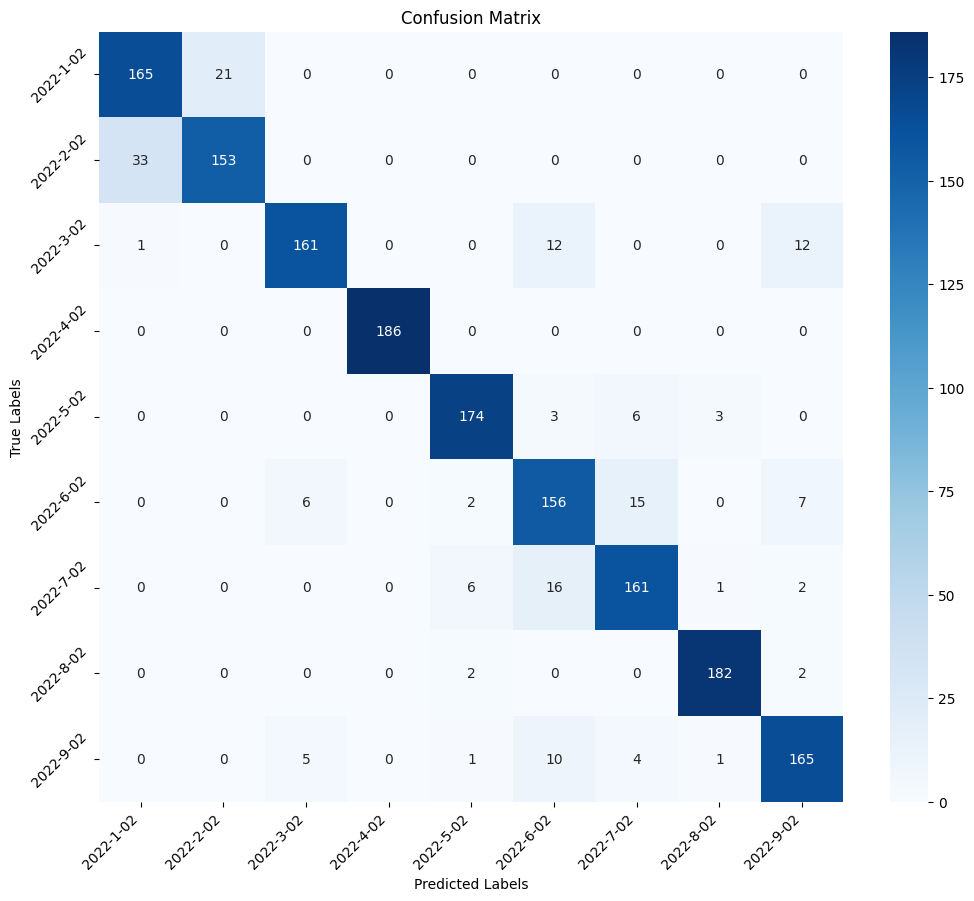

In [10]:
# Load pre training weights
checkpoint = torch.load("checkpoint/bestmodel.pkl")
model.load_state_dict(checkpoint['model_state_dict'], strict=False)
model.cuda()
start_epoch = checkpoint['epoch']


model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Make model predictions
true_labels = []
predicted_labels = []
y_scores = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        pre_scores = torch.nn.functional.softmax(outputs, dim=1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())
        y_scores.extend(pre_scores.cpu().numpy())
# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Draw confusion matrix heatmap using Seaborn
class_names = test_dataset.classes
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, ha='right')
plt.show()


## Precision_Recall_Curve

(1674,) (1674, 9)


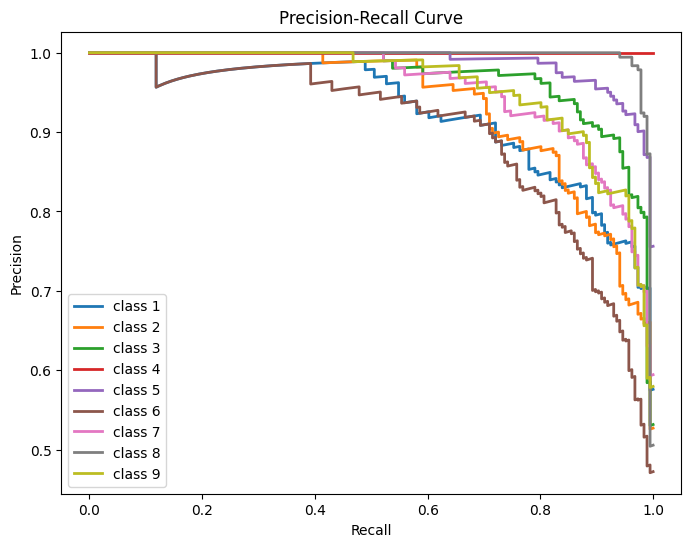

In [11]:
# Precision recall curve
num_classes=9
y_true = np.array(true_labels)
y_scores = np.array(y_scores)
print(y_true.shape,y_scores.shape)
# Convert tags to binary form
y_true_binary = label_binarize(y_true, classes=range(num_classes))


# Calculate accuracy and recall rate
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_binary[:, i], y_scores[:, i])
    average_precision[i] = average_precision_score(y_true_binary[:, i], y_scores[:, i])

# Draw precision recall curve
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i+1))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision-Recall Curve")
# plt.grid(True)
plt.show()

## Classification Report

In [12]:
# Obtain classification report
class_names = test_dataset.classes
classification_rep = classification_report(true_labels, predicted_labels, target_names=class_names, digits=4)
# Print classification report
print("\nClassification Report:")
print(classification_rep)

# Write the results to a file
output_file_path = 'result/output.txt'
# Add name identifier
report_name = 'RiceLCNN_Classification_Report:'
full_classification_rep = f"{report_name}\n\n{classification_rep}"
with open(output_file_path, 'w') as file:
    file.write("Classification Report:")
    file.write(full_classification_rep)


Classification Report:
              precision    recall  f1-score   support

   2022-1-02     0.8291    0.8871    0.8571       186
   2022-2-02     0.8793    0.8226    0.8500       186
   2022-3-02     0.9360    0.8656    0.8994       186
   2022-4-02     1.0000    1.0000    1.0000       186
   2022-5-02     0.9405    0.9355    0.9380       186
   2022-6-02     0.7919    0.8387    0.8146       186
   2022-7-02     0.8656    0.8656    0.8656       186
   2022-8-02     0.9733    0.9785    0.9759       186
   2022-9-02     0.8777    0.8871    0.8824       186

    accuracy                         0.8978      1674
   macro avg     0.8993    0.8978    0.8981      1674
weighted avg     0.8993    0.8978    0.8981      1674

